In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import nltk
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
#listing availability
#predict price
#how to achieve a good rating?
#customer review analysis

In [2]:
df_c= pd.read_csv("Seattle_Airbnb_calendar.csv")
df_c.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
df_c['newdate']= pd.to_datetime(df_c['date'])
df_c['DayOfWeek']= df_c['newdate'].dt.weekday_name
df_c['Year']=pd.DatetimeIndex(df_c['date']).year
df_c['Month']=pd.DatetimeIndex(df_c['date']).month
df_c['Month_Year']=pd.to_datetime(df_c['date']).dt.to_period('M')
df_c['available_transform'] = df_c['available'].map({'t': 1, 'f': 0})
df_c['DayofWeek_transform'] = df_c['DayOfWeek'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
df_c.head()

,listing_id,date,available,price,newdate,DayOfWeek,Year,Month,Month_Year,available_transform,DayofWeek_transform
0,241032,2016-01-04,t,$85.00,2016-01-04,Monday,2016,1,2016-01,1,1
1,241032,2016-01-05,t,$85.00,2016-01-05,Tuesday,2016,1,2016-01,1,2
2,241032,2016-01-06,f,NaN,2016-01-06,Wednesday,2016,1,2016-01,0,3
3,241032,2016-01-07,f,NaN,2016-01-07,Thursday,2016,1,2016-01,0,4
4,241032,2016-01-08,f,NaN,2016-01-08,Friday,2016,1,2016-01,0,5


DayofWeek_transform
1    0.671101
2    0.671954
3    0.671793
4    0.669743
5    0.668911
6    0.667758
7    0.673001
Name: available_transform, dtype: float64


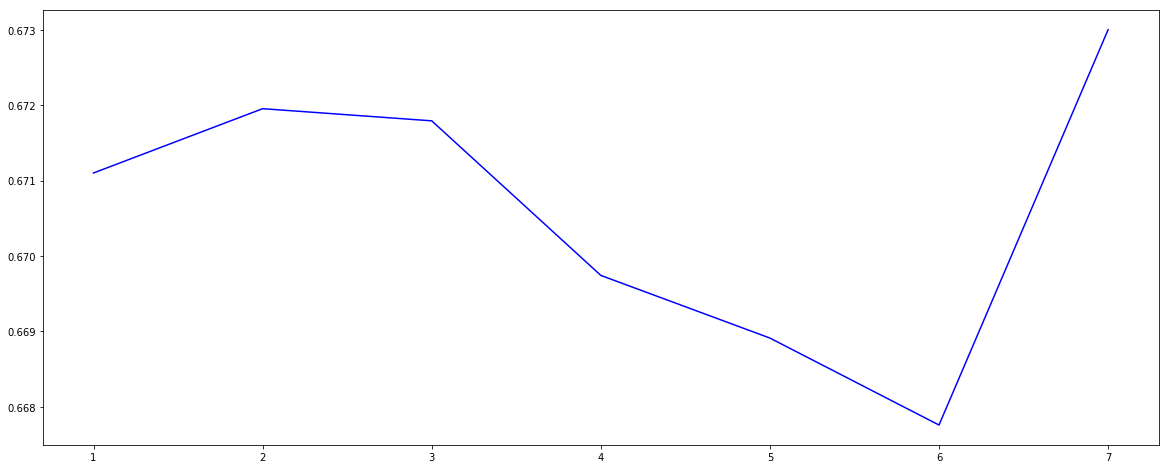

In [9]:
#listing availability by day of week
AvailabilityByWeekDay= df_c.groupby(['DayofWeek_transform'] )['available_transform'].sum()/df_c.groupby(['DayofWeek_transform'])['available_transform'].count()
print(AvailabilityByWeekDay)
plt.figure(figsize = (20,8))
plt.plot(AvailabilityByWeekDay,color='blue')

Month
1     0.566937
2     0.662208
3     0.709187
4     0.663847
5     0.675670
6     0.674384
7     0.627097
8     0.645051
9     0.674402
10    0.696514
11    0.713986
12    0.735573
Name: available_transform, dtype: float64


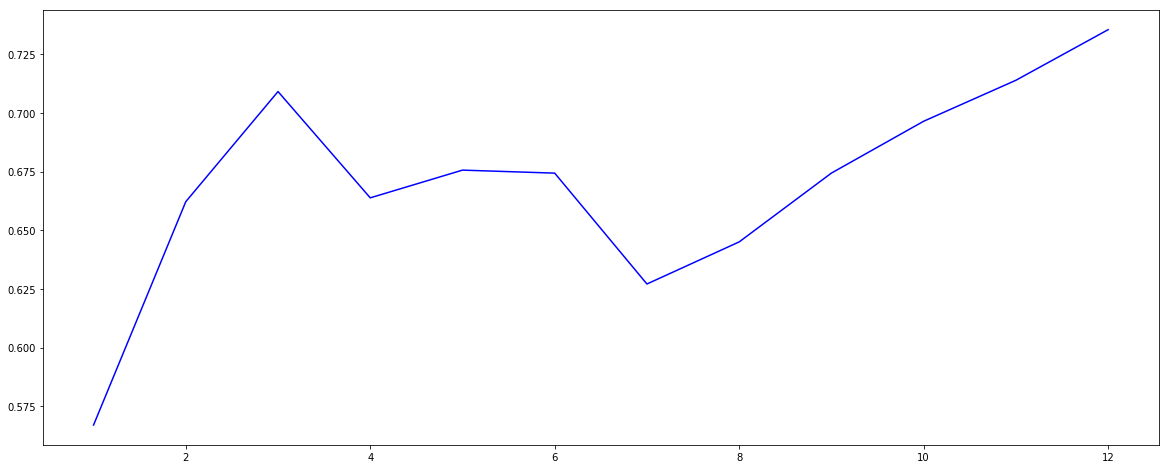

In [96]:
#listing availabiity by month
AvailabilityByMonth = df_c.groupby(['Month'])['available_transform'].sum()/df_c.groupby(['Month'])['available_transform'].count()
print(AvailabilityByMonth)
plt.figure(figsize = (20,8))
plt.plot(AvailabilityByMonth,color='blue')

In [102]:
#convert price type from string to float
df_c['price']=(df_c['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

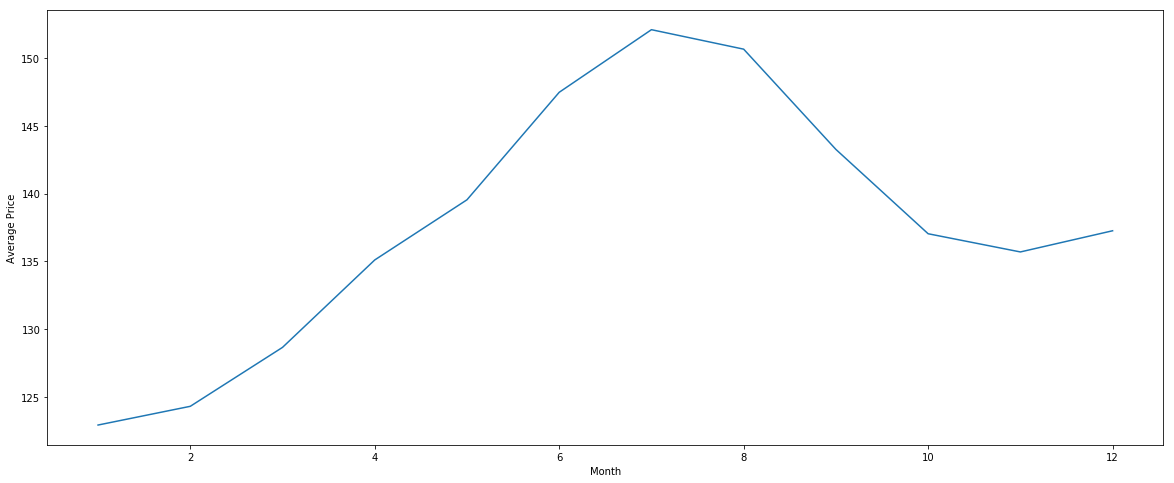

In [107]:
#what is the average price per month?
plt.figure(figsize = (20,8))
AvgPriceByMonth = df_c.groupby(['Month'])['price'].mean()
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.plot(AvgPriceByMonth )

In [59]:
df_l= pd.read_csv("Seattle_Airbnb_listings.csv")
df_l.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [60]:
 df_l.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3818,3.818000e+03,3818,3818,3641,3249,3818,3818,2786,...,3162.000000,3818,0.0,3818,3818,3818,3818,3818,3818.000000,3191.000000
unique,NaN,3818,NaN,1,3792,3478,3119,3742,1,2506,...,NaN,1,NaN,1,2,3,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/6992387,NaN,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,...,NaN,f,NaN,WASHINGTON,f,strict,f,f,NaN,NaN
freq,NaN,1,NaN,3818,3,15,14,10,3818,17,...,NaN,3818,NaN,3818,3227,1417,3497,3443,NaN,NaN
mean,5.550111e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.452245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.946307,2.078919
std,2.962660e+06,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.893029,1.822348
min,3.335000e+03,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.020000
25%,3.258256e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.695000
50%,6.118244e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.540000
75%,8.035127e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,3.000000


In [65]:
df_l.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [61]:
#check if id only contains unique values
pd.Series(df_l['id']).is_unique

True

In [71]:
df_l.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [32]:
df_l[['id','city','state','zipcode','country','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','neighbourhood','price']]

,id,city,state,zipcode,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,neighbourhood,price
0,241032,Seattle,WA,98119,United States,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,Queen Anne,85.0
1,953595,Seattle,WA,98119,United States,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,Queen Anne,150.0
2,3308979,Seattle,WA,98119,United States,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,Queen Anne,975.0
3,7421966,Seattle,WA,98119,United States,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,Queen Anne,100.0
4,278830,Seattle,WA,98119,United States,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,Queen Anne,450.0
5,5956968,Seattle,WA,98119,United States,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",NaN,Queen Anne,120.0
6,1909058,Seattle,WA,98119,United States,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",NaN,Queen Anne,80.0
7,856550,Seattle,WA,98119,United States,Cabin,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Pets live on this proper...",NaN,Queen Anne,60.0
8,4948745,Seattle,WA,98109,United States,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,Queen Anne,90.0
9,2493658,Seattle,WA,98119,United States,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,Queen Anne,150.0


In [ ]:
df_l[['id','host_id','host_response_time','host_acceptance_rate','price','security_deposit','cleaning_fee','guests_included','extra_people','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

In [110]:
#convert price type from string to float
df_l['price']=(df_l['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

In [53]:
df_l['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

In [54]:
df_l['price'].var()
df_l['price'].std()
df_l['price'].skew()

3.113122670038106

Text(0,0.5,'Frequency')

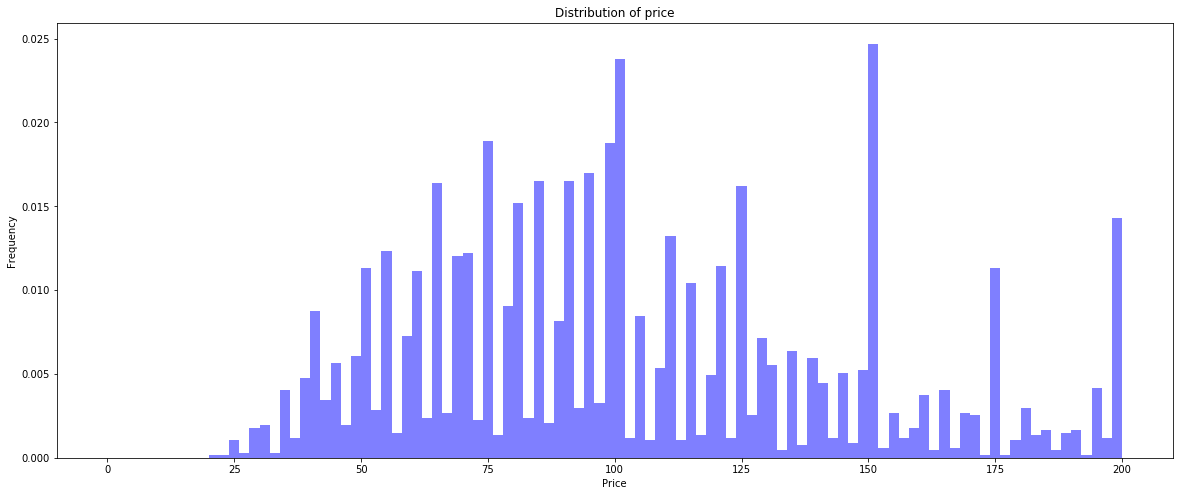

In [76]:
#Distribution of price
plt.figure(figsize = (20,8))
plt.hist(df_l['price'], bins=100, normed=True, alpha=0.5,
         histtype='stepfilled', color='blue',
         edgecolor='none',range=(0,200));
plt.title('Distribution of price')
plt.xlabel('Price')
plt.ylabel('Frequency')

In [77]:
df_l['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

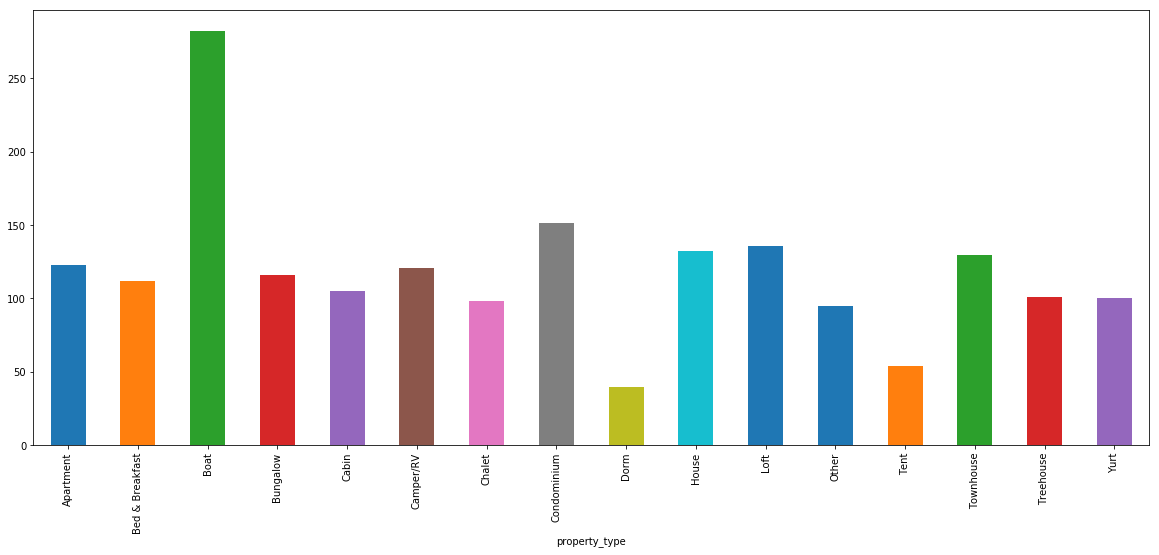

In [78]:
#avg price by property_type
plt.figure(figsize = (20,8))
df_l.groupby('property_type')['price'].mean().plot(kind='bar')
plt.show()

In [13]:
df_l['neighbourhood'].value_counts()

Capitol Hill                 351
Ballard                      213
Belltown                     204
Minor                        192
Queen Anne                   187
Fremont                      148
Wallingford                  143
University District          107
First Hill                   105
Stevens                       98
North Beacon Hill             95
Lower Queen Anne              83
Central Business District     81
Greenwood                     79
Columbia City                 61
Ravenna                       59
Phinney Ridge                 56
Magnolia                      55
Green Lake                    52
Atlantic                      50
North Admiral                 48
Mount Baker                   46
Leschi                        44
Maple Leaf                    41
Eastlake                      41
Madrona                       40
Pike Place Market             39
The Junction                  36
Seward Park                   32
Bryant                        32
          

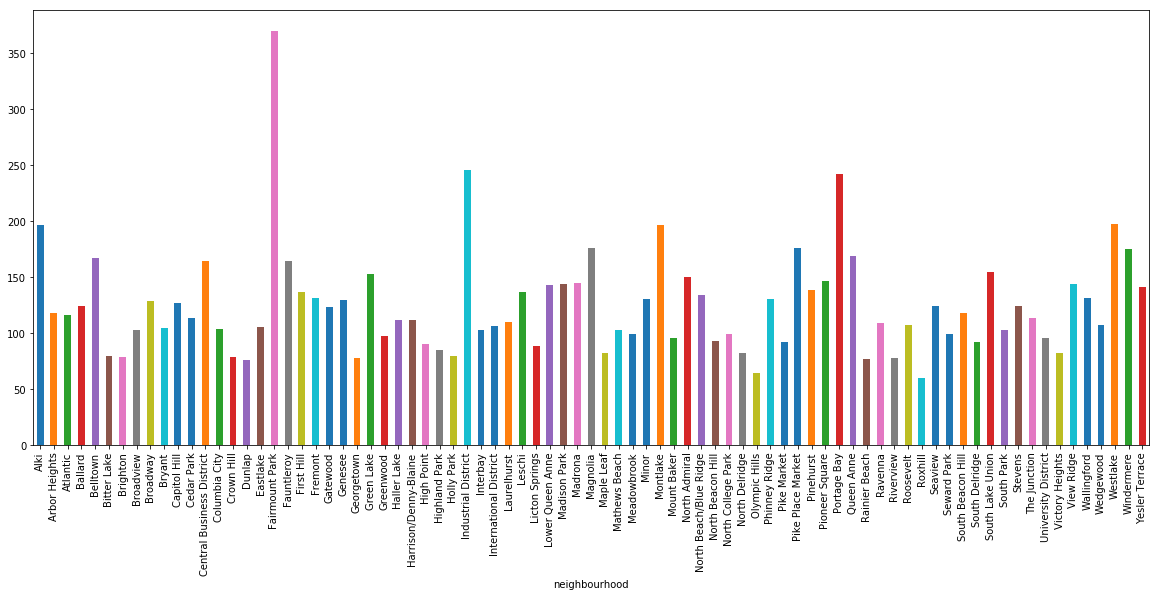

In [80]:
#avg price by neighbourhood
plt.figure(figsize = (20,8))
df_l.groupby('neighbourhood')['price'].mean().plot(kind='bar')
plt.show()

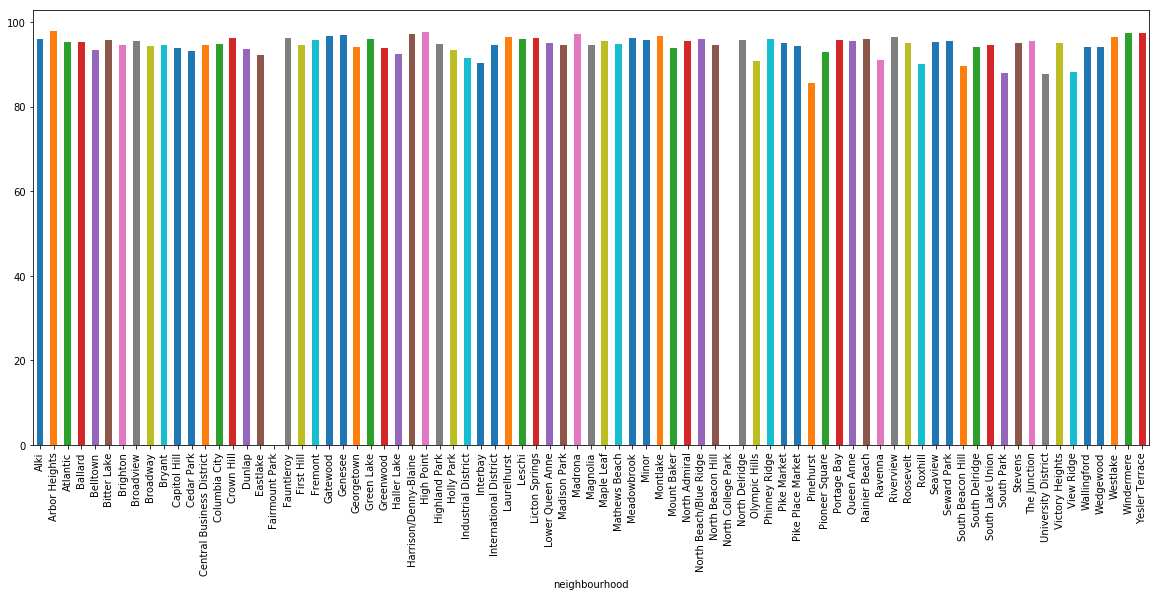

In [15]:
#avg review score by neighbourhood
plt.figure(figsize = (20,8))
df_l.groupby('neighbourhood')['review_scores_rating'].mean().plot(kind='bar')
plt.show()

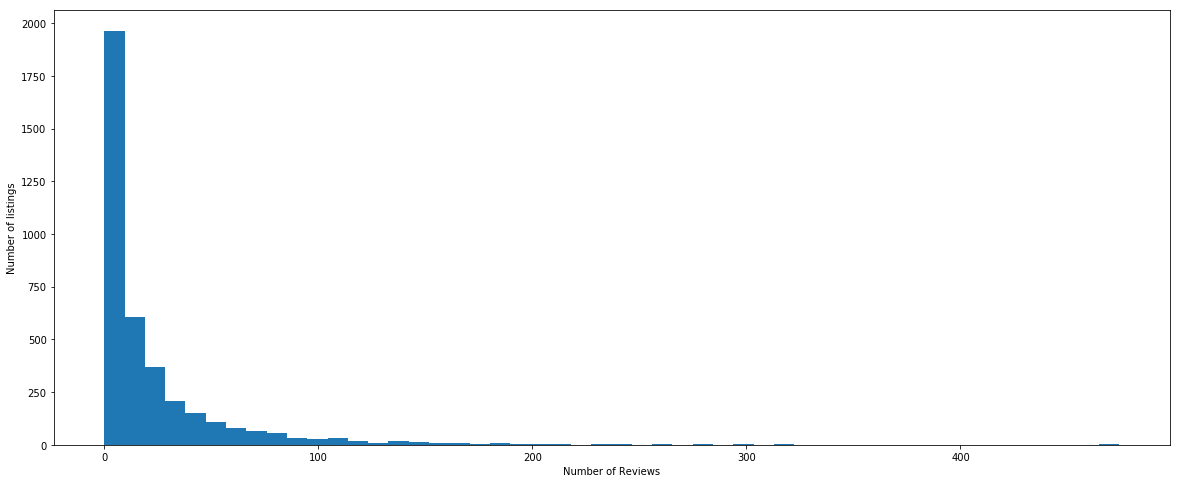

In [88]:
#avg number of reviews posted for each listing?
plt.figure(figsize = (20,8))
df_l.groupby('id')['number_of_reviews'].mean().plot(kind='hist',bins=50)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of listings')
plt.show()

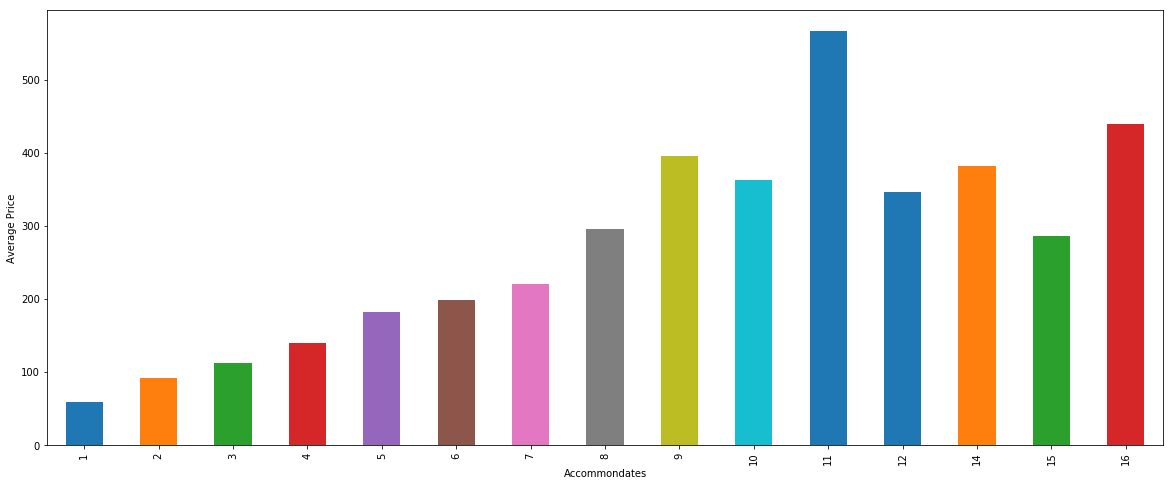

In [116]:
#What is the average price for each accommodates type?
plt.figure(figsize=(20,8))
df_l.groupby(['accommodates'])['price'].mean().plot(kind='bar')
plt.xlabel('Accommondates')
plt.ylabel('Average Price')
plt.show()


In [62]:
#data preparation --predict listing price
df = df_l[["host_response_rate", "host_acceptance_rate", "host_is_superhost",
               "host_listings_count", "zipcode", "property_type","room_type", "accommodates", "bathrooms", "bedrooms", 
               "beds", "price", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]

In [63]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month
0,96%,100%,f,3.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$85.00,207,95.0,moderate,4.07
1,98%,100%,t,6.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$150.00,43,96.0,strict,1.48
2,67%,100%,f,2.0,98119,House,Entire home/apt,11,4.5,5.0,7.0,$975.00,20,97.0,strict,1.15
3,NaN,NaN,f,1.0,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,$100.00,0,NaN,flexible,NaN
4,100%,NaN,f,2.0,98119,House,Entire home/apt,6,2.0,3.0,3.0,$450.00,38,92.0,strict,0.89


In [65]:
# drop NaN rows
df2=df.dropna(axis=0)

In [66]:
pd.options.mode.chained_assignment = None  # default='warn'

df2['host_response_rate'] = df2['host_response_rate'].astype(str)
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].astype(str)
df2['price'] = df2['price'].astype(str)

In [67]:
# clean data
pd.options.mode.chained_assignment = None  # default='warn'
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].str.replace("%", "").astype("float")
df2['price'] = df2['price'].str.replace("[$, ]", "").astype("float")
df2['host_response_rate'] = df2['host_response_rate'].str.replace("%", "").astype("float")

In [68]:
df2['superhost']=np.where(df2['host_is_superhost']=='t',1,0)
del df2['host_is_superhost']

In [69]:
# select non-numeric variables and create dummies
non_num_vars = df2.select_dtypes(include=['object']).columns
df2[non_num_vars].head()

,zipcode,property_type,room_type,cancellation_policy
0,98119,Apartment,Entire home/apt,moderate
1,98119,Apartment,Entire home/apt,strict
2,98119,House,Entire home/apt,strict
6,98119,House,Private room,moderate
7,98119,Cabin,Private room,strict


In [ ]:
# select non-numeric variables and create dummies
non_num_vars = df2.select_dtypes(include=['object']).columns
df2[non_num_vars].head()

In [70]:
dummy_vars = pd.get_dummies(df2[non_num_vars])

In [71]:
dummy_vars.head()

,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [72]:
# drop non-numeric variables from df2 and add the dummies
df3=df2.drop(non_num_vars,axis=1)
df3 = pd.merge(df3,dummy_vars, left_index=True, right_index=True)
df3.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,96.0,100.0,3.0,4,1.0,1.0,1.0,85.0,207,95.0,...,0,0,0,0,1,0,0,0,1,0
1,98.0,100.0,6.0,4,1.0,1.0,1.0,150.0,43,96.0,...,0,0,0,0,1,0,0,0,0,1
2,67.0,100.0,2.0,11,4.5,5.0,7.0,975.0,20,97.0,...,0,0,0,0,1,0,0,0,0,1
6,100.0,100.0,1.0,2,1.0,1.0,1.0,80.0,58,99.0,...,0,0,0,0,0,1,0,0,1,0
7,100.0,100.0,5.0,2,1.0,1.0,1.0,60.0,173,97.0,...,0,0,0,0,0,1,0,0,0,1


In [74]:
cols = ['number_of_reviews','host_acceptance_rate','host_listings_count','accommodates',
       'bathrooms','bedrooms','beds','price']

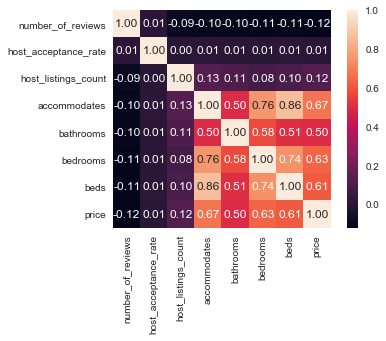

In [75]:
# heatmap
corrs = np.corrcoef(df3[cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols)

In [79]:
#prediction
#linear model
y = df3['price']
x = df3.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
slr = linear_model.LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 2531.745, test: 2357.700
R^2 train: 0.613, test: 0.658


In [82]:
#random forest
RF = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
RF.fit(X_train, y_train)

#calculate scores for the model
y_train_preds = RF.predict(X_train)
y_test_preds = RF.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 366.925, test: 2330.597
Random Forest R^2 train: 0.944, test: 0.662


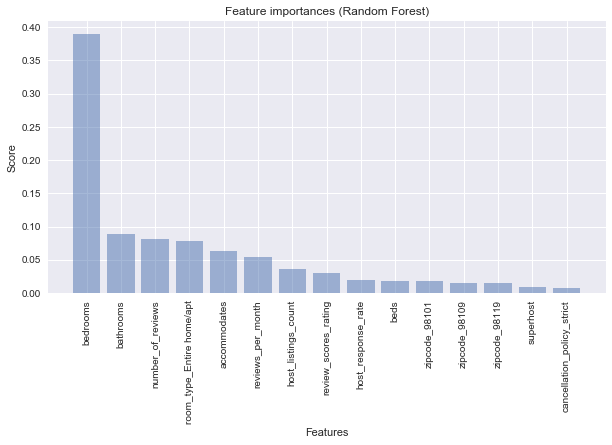

In [85]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, RF.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

In [43]:
#import reviews
df_r= pd.read_csv('Seattle_Airbnb_reviews.csv',encoding='utf-8')
df_r.head()
df_r.shape

(84849, 6)

In [44]:
df_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [45]:
df_r['comments'].isnull().sum()

18

In [46]:
df_r=df_r.dropna(subset=['comments'])

In [47]:
df_r['Month_Year']=pd.to_datetime(df_r['date']).dt.to_period('M')

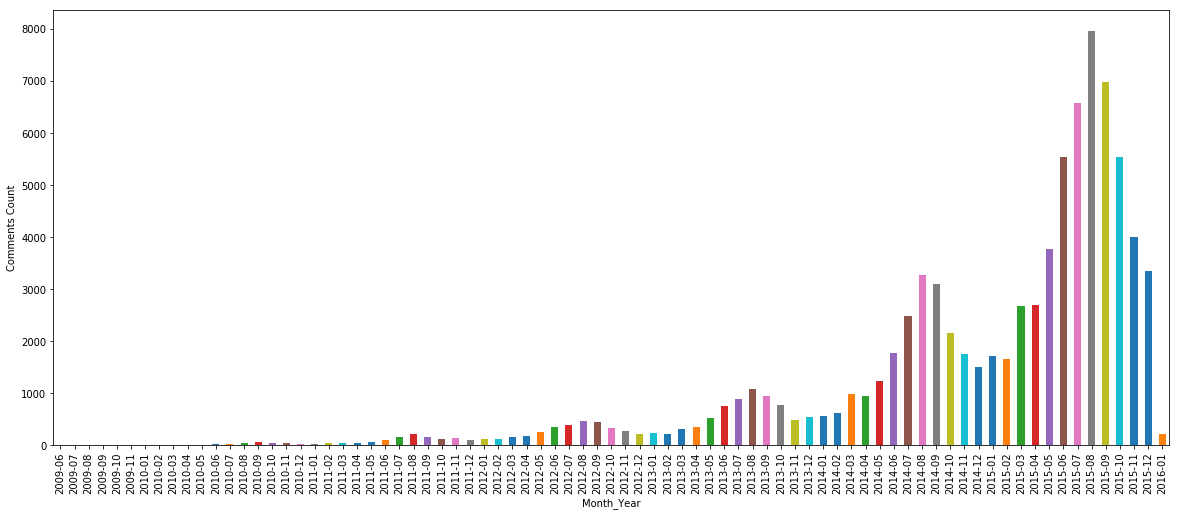

In [50]:
plt.figure(figsize=(20,8))
df_r.groupby(['Month_Year'])['reviewer_id'].count().plot(kind='bar')
plt.xlabel('Month_Year')
plt.ylabel('Comments Count')
plt.show()

In [52]:
sid = SentimentIntensityAnalyzer()
df_r['neg'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['neg'])
df_r['neu'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['neu'])
df_r['pos'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['pos'])
df_r['compound'] = df_r['comments'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [54]:
df_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Month_Year,neg,neu,pos,compound
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,2015-07,0.000,0.462,0.538,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,2015-07,0.000,0.609,0.391,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",2015-07,0.043,0.772,0.185,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,2015-08,0.035,0.765,0.200,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,2015-08,0.000,0.655,0.345,0.9783


In [56]:
pos_comments = 0
neu_comments = 0
neg_comments = 0
for index, row in df_r.iterrows(): 
    if(row['compound']>0.2):
        pos_comments += 1
    if(0.2>= row['compound']>= -0.2):
        neu_comments += 1
    if (row['compound']<-0.2):
        neg_comments += 1
       

In [58]:
print('Percentage of positive review: {}%'.format((pos_comments)*100/len(df_r['comments'])))
print('Percentage of neutral review: {}%'.format((neu_comments)*100/len(df_r['comments'])))
print('Percentage of nwgative review: {}%'.format((neg_comments)*100/len(df_r['comments'])))

Percentage of positive review: 96.9374403225236%
Percentage of neutral review: 2.2574294774315993%
Percentage of nwgative review: 0.805130200044795%
